In [30]:
import numpy as np
from stable_baselines3 import DQN
from gymnasium import spaces, Env

class CustomGridEnv(Env):
    """Custom Grid environment that follows Gym API (inherits from gym.Env)."""
    
    def __init__(self, grid_size, num_objects):
        super(CustomGridEnv, self).__init__()
        self.grid_size = grid_size
        self.num_objects = num_objects
        
        # Action space: Choose a position on the grid (discrete)
        self.action_space = spaces.Discrete(grid_size * grid_size)
        
        # Observation space: Flattened grid with 0 (empty) and 1 (object)
        self.observation_space = spaces.Box(low=0, high=1, shape=(grid_size * grid_size,), dtype=np.int32)
        
        self.grid = np.zeros((grid_size, grid_size), dtype=int)  # Initialize grid
        self.seed_val = None  # To store seed if provided

    def reset(self, seed=None):
        """Resets the environment and returns the initial observation."""
        # Optional: Apply the seed for reproducibility
        if seed is not None:
            self.seed_val = seed
            np.random.seed(seed)
        
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self.current_object = 0  # Track how many objects have been placed
        self.placed_positions = set()  # Keep track of placed positions
        return self.grid.flatten(), {}

    def step(self, action):
        """Places an object at the given position."""
        # Decode action (row, col)
        row = action // self.grid_size
        col = action % self.grid_size

        # If the position is already occupied, return a negative reward
        if (row, col) in self.placed_positions:
            return self.grid.flatten(), -1, False, {}

        # Place the object
        self.grid[row, col] = 1
        self.placed_positions.add((row, col))

        self.current_object += 1

        # Check if all objects are placed
        done = self.current_object == self.num_objects

        # Calculate reward
        reward = 1 if not done else 10  # Reward for placing objects, bonus on completion

        return self.grid.flatten(), reward, done, {}

    def render(self):
        """Render the grid (can print or visualize)."""
        print(self.grid)

# Train the DQN model with gym-compatible environment
def train_model():
    # Create an instance of the custom environment
    grid_size = 20
    num_objects = 5
    env = CustomGridEnv(grid_size, num_objects)

    # Initialize DQN model
    model = DQN("MlpPolicy", env, verbose=1)

    # Train the model
    model.learn(total_timesteps=10000)

    # Save the trained model
    model.save("dqn_grid_object_placement")

    print("Training completed and model saved!")

if __name__ == "__main__":
    train_model()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


ValueError: not enough values to unpack (expected 5, got 4)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 14       |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 19976    |
|    time_elapsed     | 0        |
|    total_timesteps  | 20       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 14       |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 19988    |
|    time_elapsed     | 0        |
|    total_timesteps  | 40       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 14     

C:\Users\yongl\AppData\Local\Temp\ipykernel_7896\2587548724.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", self.num_objects + 1)  # Get a colormap with enough colors


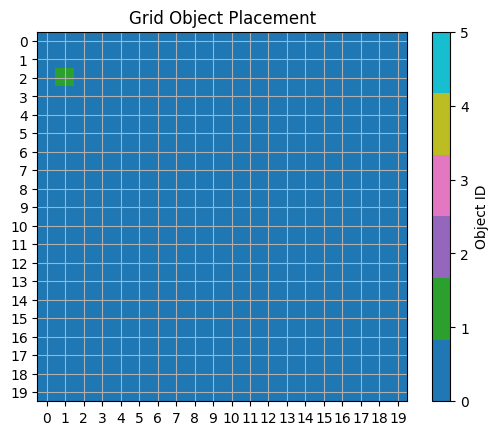

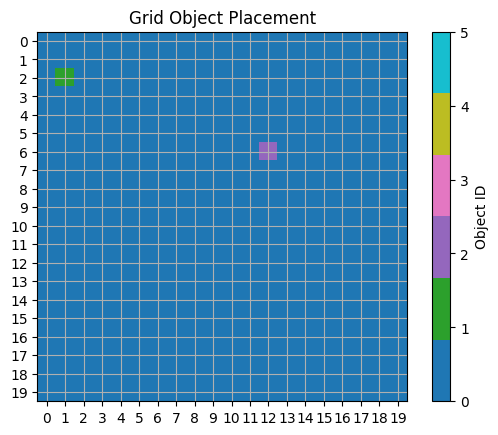

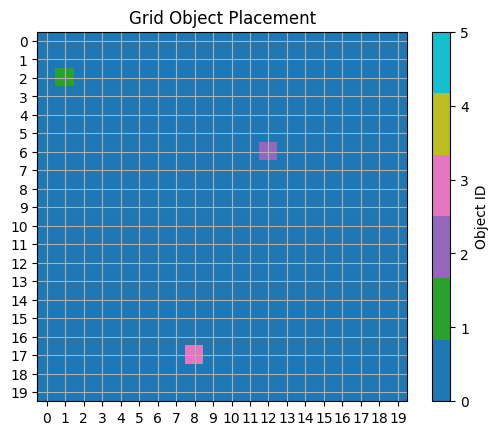

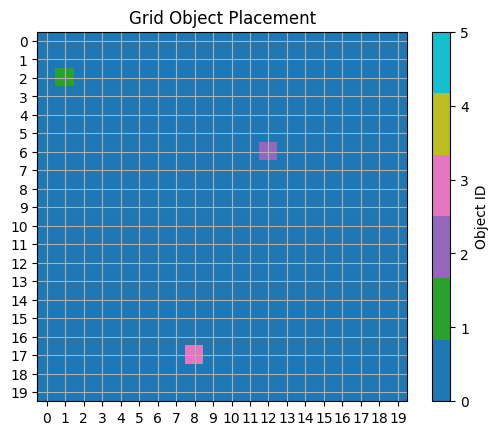

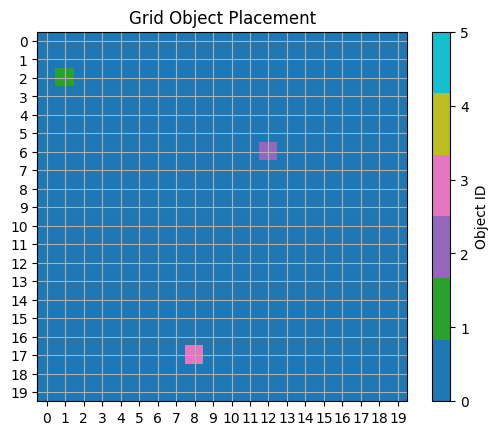

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from gymnasium import spaces, Env

class CustomGridEnv(Env):
    """Custom Grid environment that follows Gym API (inherits from gym.Env)."""
    
    def __init__(self, grid_size, num_objects):
        super(CustomGridEnv, self).__init__()
        self.grid_size = grid_size
        self.num_objects = num_objects
        
        # Action space: Choose a position on the grid (discrete)
        self.action_space = spaces.Discrete(grid_size * grid_size)
        
        # Observation space: Flattened grid with 0 (empty) and unique values for each object
        self.observation_space = spaces.Box(low=0, high=self.num_objects, shape=(grid_size * grid_size,), dtype=np.int32)
        
        self.grid = np.zeros((grid_size, grid_size), dtype=int)  # Initialize grid
        self.seed_val = None  # To store seed if provided

    def reset(self, seed=None):
        """Resets the environment and returns the initial observation."""
        # Optional: Apply the seed for reproducibility
        if seed is not None:
            self.seed_val = seed
            np.random.seed(seed)
        
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self.current_object = 0  # Track how many objects have been placed
        self.placed_positions = set()  # Keep track of placed positions
        return self.grid.flatten(), {}

    def step(self, action):
        """Places an object at the given position."""
        # Decode action (row, col)
        row = action // self.grid_size
        col = action % self.grid_size

        # If the position is already occupied, return a negative reward
        if (row, col) in self.placed_positions:
            return self.grid.flatten(), -1, False, False, {}

        # Place the object with a unique number (object id)
        self.grid[row, col] = self.current_object + 1
        self.placed_positions.add((row, col))

        self.current_object += 1

        # Check if all objects are placed
        done = self.current_object == self.num_objects

        # Calculate reward
        reward = 1 if not done else 10  # Reward for placing objects, bonus on completion

        # `terminated` is True if the task is done
        terminated = done
        # `truncated` is False as we are not using time limits or external stopping
        truncated = False

        return self.grid.flatten(), reward, terminated, truncated, {}

    def render(self):
        """Render the grid using matplotlib with unique colors for each object."""
        cmap = plt.cm.get_cmap("tab10", self.num_objects + 1)  # Get a colormap with enough colors
        plt.imshow(self.grid, cmap=cmap, vmin=0, vmax=self.num_objects)
        plt.title("Grid Object Placement")
        plt.xticks(np.arange(self.grid_size))
        plt.yticks(np.arange(self.grid_size))
        plt.colorbar(ticks=np.arange(self.num_objects + 1), label="Object ID")
        plt.grid(True)
        plt.show()


# Train the DQN model with gym-compatible environment
def train_model():
    # Create an instance of the custom environment
    grid_size = 20
    num_objects = 5
    env = CustomGridEnv(grid_size, num_objects)

    # Initialize DQN model
    model = DQN("MlpPolicy", env, verbose=1)

    # Train the model
    model.learn(total_timesteps=10000)

    # Save the trained model
    model.save("dqn_grid_object_placement")

    print("Training completed and model saved!")

def visualize_model():
    # Load the trained model
    model = DQN.load("dqn_grid_object_placement")

    # Create an instance of the custom environment
    grid_size = 20
    num_objects = 5
    env = CustomGridEnv(grid_size, num_objects)

    obs, _ = env.reset()

    for _ in range(num_objects):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)

        # Render the current state of the grid
        env.render()

        if done:
            break

if __name__ == "__main__":
    # Uncomment the following line to train the model
    train_model()

    # Visualize how the trained model places objects on the grid
    visualize_model()
